# Wrangle and Analyze Data
## Data Wrangling

In [1]:
# Import modules and setup notebook
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import tweepy
import time
import ipywidgets as widgets

%matplotlib inline
sns.set_style('dark')
sns.set_context('notebook')

### Gather
1. twitter csv data: `'twitter-archive-enhanced.csv'`
2. image predictions tsv file: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv
3. scraped Twitter data: Twitter API  

#### 1. Twitter CSV Data _(Provided)_

In [2]:
# 1. provided twitter csv data:
twitter_csv = pd.read_csv('twitter-archive-enhanced.csv')
twitter_csv.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
2089,670789397210615808,NaN,NaN,2015-11-29 02:20:29 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Two obedient dogs here. Left one has extra leg...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670789397...,9,10,None,None,None,None,None
963,750719632563142656,NaN,NaN,2016-07-06 15:54:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Meyer. He has to hold somebody's hand ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/750719632...,12,10,Meyer,None,None,None,None
1045,743595368194129920,NaN,NaN,2016-06-17 00:05:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Harold. He looks slippery af. Probably...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/743595368...,7,10,Harold,None,None,None,None
1085,738184450748633089,NaN,NaN,2016-06-02 01:44:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...","For the last time, we only rate dogs. Pls stop...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/738184450...,9,10,None,None,None,None,None


#### 2. Image Predictions TSV File (Requests Library)

In [3]:
# 2. image predictions tsv file:
predictions_url = 'https://d17h27t6h515a5.cloudfront.net/topher' \
                  '/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

# GET tsv file and write response to file before reading into dataframe
r = requests.request('GET', predictions_url)
with open('image-predictions.tsv', 'wb') as f:
    f.write(r.content)
    
image_predictions = pd.read_csv('image-predictions.tsv', sep='\t')
image_predictions.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
470,675113801096802304,https://pbs.twimg.com/media/CV58a4nXAAApywo.jpg,1,bow,0.168020,False,quill,0.108807,False,joystick,0.043312,False
420,674042553264685056,https://pbs.twimg.com/media/CVquIDRW4AEJrPk.jpg,1,toy_poodle,0.927975,True,miniature_poodle,0.068946,True,standard_poodle,0.001316,True
461,674800520222154752,https://pbs.twimg.com/media/CV1ffl3XAAAiFyr.jpg,1,Pembroke,0.876479,True,Cardigan,0.096911,True,dingo,0.009196,False
397,673662677122719744,https://pbs.twimg.com/media/CVlUfBbUwAQyfcD.jpg,1,Labrador_retriever,0.957670,True,beagle,0.012413,True,golden_retriever,0.005689,True
1731,821107785811234820,https://pbs.twimg.com/media/C2UpLA-UcAEK_Fz.jpg,1,Pomeranian,0.856590,True,papillon,0.038537,True,Yorkshire_terrier,0.033146,True


#### 3. Scraped Twitter data via Tweepy API
##### Setup Twitter Authentication and Tweepy API

In [4]:
consumer_key = CONSUMER_KEY
consumer_secret = CONSUMER_SECRET
access_token = ACCESS_TOKEN
access_secret = ACCESS_SECRET

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth,
                 parser=tweepy.parsers.JSONParser(),
                 wait_on_rate_limit=True,
                 wait_on_rate_limit_notify=True)

##### Read Tweets and Write to Text File

In [19]:
# error_list logs tweets that fail to pull via API
error_list = []

# time the duration of API request
start = time.time()

#context manager for retrieving, writing tweets to text file
with open('tweet_json.txt', 'w', encoding='utf8') as f:
    for tweet_id in twitter_csv.tweet_id:
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("{0}: Successful".format(tweet_id))
            json.dump(tweet, f)
            f.write('\n')
        except Exception as e:
            print("{0}: {1}".format(tweet_id, e))
            error_list.append(tweet_id)
            
finish = time.time()

print("\nSuccessful queries: {0} tweets".format(len(twitter_csv.tweet_id) - len(error_list)))
print("Failed queries: {0}\n".format(len(error_list)))

minutes, seconds = divmod(finish - start, 60)
print("Elapsed time: {0} minutes {1} seconds".format(minutes, seconds))

670783437142401025: Successful
824025158776213504: Successful
670822709593571328: Successful
674664755118911488: Successful
775898661951791106: Successful

Successful queries: 2356 tweets
Failed queries: 0

Elapsed time: 0.0 minutes 1.102341651916504 seconds


In [6]:
# retry error tweets
print("Attempting {0} tweets again...".format(len(error_list)))
error_queue = list(error_list)

for tweet_id in error_queue:
    try:
        tweet = api.get_status(tweet_id)
        error_queue.remove(tweet_id)
    except Exception as e:
        print("{0}: {1}".format(tweet_id, e))
            
print("Failed again: {0}".format(len(error_list)))

Attempting 11 tweets again...
888202515573088257: [{'code': 144, 'message': 'No status found with that ID.'}]
873697596434513921: [{'code': 144, 'message': 'No status found with that ID.'}]
869988702071779329: [{'code': 144, 'message': 'No status found with that ID.'}]
866816280283807744: [{'code': 144, 'message': 'No status found with that ID.'}]
861769973181624320: [{'code': 144, 'message': 'No status found with that ID.'}]
845459076796616705: [{'code': 144, 'message': 'No status found with that ID.'}]
842892208864923648: [{'code': 144, 'message': 'No status found with that ID.'}]
837012587749474308: [{'code': 144, 'message': 'No status found with that ID.'}]
827228250799742977: [{'code': 144, 'message': 'No status found with that ID.'}]
802247111496568832: [{'code': 144, 'message': 'No status found with that ID.'}]
775096608509886464: [{'code': 144, 'message': 'No status found with that ID.'}]
Failed again: 11


The same 11 tweets failed again with the same code, 144. It appears those tweets may have been deleted.  

##### Read Tweets from Text File into Pandas DataFrame

In [4]:
# build DataFrame using recommended method: list of dictionaries
# https://stackoverflow.com/questions/28056171/
#         how-to-build-and-fill-pandas-dataframe-from-for-loop/28058264#28058264
df_list = []

with open('tweet_json.txt', 'r', encoding='utf8') as f:
    for line in f:
        tweet_line = json.loads(line)
        df_list.append({'tweet_id': tweet_line['id'],
                        'favorites': tweet_line['favorite_count'],
                        'retweets': tweet_line['retweet_count'],
                        'retweeted': tweet_line['retweeted'],
                        'followers': tweet_line['user']['followers_count'],
                        'full_text': tweet_line['full_text'][:]})
        
tweepy_data = pd.DataFrame(df_list)

### Assess
#### Visually

In [5]:
twitter_clean = twitter_csv.copy()
image_clean = image_predictions.copy()
tweepy_clean = tweepy_data.copy()

In [7]:
twitter_clean

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


`twitter_clean` columns
- **tweet_id** : ID for that particular status
- **in_reply_to_status_id** : ID for status in reply to (if applicable)
- **in_reply_to_user_id** : user ID whose status was being replied to (if applicable)
- **timestamp** : time of tweet
- **source** : link to download Twitter application
- **text** : text of tweet
- **retweeted_status_id** : ID of status retweeting We Rate Dogs
- **retweeted_status_user_id** : user ID for retweeter
- **retweeted_status_timestamp** : timestamp of retweet
- **expanded_urls** : URL of tweet
- **rating_numerator** : although rated on a 10 point scale, many numerators are 10+
- **rating_denominator** : typically 10 to indicate 10 point scale
- **name** : dog's name
- **doggo**, **floofer**, **pupper**, **puppo** : unique terminology for dogs as created by We Rate Dogs

In [38]:
image_clean

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


`image_clean` columns
- **tweet_id** : ID for that particular status
- **jpg_url** : url for image posted to twitter
- **img_num** : number of images in tweet
- **p1** : #1 prediction
- **p1_conf** : confidence level of #1 prediction
- **p1_dog** : boolean of #1 prediction is a dog breed
- **p2** : #2 prediction
- **p2_conf** : confidence level of #2 prediction
- **p2_dog** : boolean of #2 prediction is a dog breed
- **p3** : #3 prediction
- **p3_conf** : confidence level of #3 prediction
- **p3_dog** : boolean of #3 prediction is a dog breed

In [8]:
tweepy_clean

,favorites,followers,full_text,hashtags,retweeted,retweets,timestamp,tweet_id
0,38990,6297542,This is Phineas. He's a mystical boy. Only eve...,[],False,8653,Tue Aug 01 16:23:56 +0000 2017,892420643555336193
1,33392,6297541,This is Tilly. She's just checking pup on you....,[],False,6355,Tue Aug 01 00:17:27 +0000 2017,892177421306343426
2,25167,6297541,This is Archie. He is a rare Norwegian Pouncin...,[],False,4220,Mon Jul 31 00:18:03 +0000 2017,891815181378084864
3,42347,6297541,This is Darla. She commenced a snooze mid meal...,[],False,8767,Sun Jul 30 15:58:51 +0000 2017,891689557279858688
4,40519,6297542,This is Franklin. He would like you to stop ca...,"[{'text': 'BarkWeek', 'indices': [129, 138]}]",False,9531,Sat Jul 29 16:00:24 +0000 2017,891327558926688256
5,20320,6297542,Here we have a majestic great white breaching ...,"[{'text': 'BarkWeek', 'indices': [129, 138]}]",False,3161,Sat Jul 29 00:08:17 +0000 2017,891087950875897856
6,11911,6297542,Meet Jax. He enjoys ice cream so much he gets ...,[],False,2106,Fri Jul 28 16:27:12 +0000 2017,890971913173991426
7,65894,6297542,When you watch your owner call another dog a g...,[],False,19182,Fri Jul 28 00:22:40 +0000 2017,890729181411237888
8,27907,6297542,This is Zoey. She doesn't want to be one of th...,"[{'text': 'BarkWeek', 'indices': [113, 122]}]",False,4324,Thu Jul 27 16:25:51 +0000 2017,890609185150312448
9,32092,6297542,This is Cassie. She is a college pup. Studying...,[],False,7533,Wed Jul 26 15:59:51 +0000 2017,890240255349198849


`tweepy_clean` columns
- **favorites** : count of status favorites by twitter users
- **img_num** : number of We Rate Dog followers at the time of posting status update
- **hashtags** : dictionary of hashtags (if applicable)
- **retweeted** : boolean value indicating if tweet is original (False) or retweet (True)
- **timestamp** : time of status update
- **tweet_id** : ID for that particular status

#### Programmatically

In [59]:
twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [32]:
twitter_clean.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [11]:
# test for duplicate tweets
twitter_clean.tweet_id.duplicated().sum()

0

In [31]:
len(twitter_clean[twitter_clean['text'].str.startswith('RT') == False])

2173

In [9]:
twitter_clean.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [10]:
twitter_clean.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [7]:
twitter_clean.name.value_counts()

None         745
a             55
Charlie       12
Oliver        11
Lucy          11
Cooper        11
Lola          10
Tucker        10
Penny         10
Bo             9
Winston        9
Sadie          8
the            8
Buddy          7
Daisy          7
an             7
Bailey         7
Toby           7
Leo            6
Stanley        6
Bella          6
Scout          6
Rusty          6
Oscar          6
Jax            6
Milo           6
Dave           6
Koda           6
Jack           6
Louis          5
            ... 
Thor           1
Luther         1
Hamrick        1
Covach         1
Wesley         1
Orion          1
JD             1
Tassy          1
Shnuggles      1
Lugan          1
Lassie         1
Griswold       1
Vince          1
Bones          1
Trigger        1
Miley          1
Rupert         1
Ginger         1
Mingus         1
Rufio          1
Striker        1
Geoff          1
Skye           1
Cheesy         1
Chevy          1
Bruiser        1
Crouton        1
Rontu         

In [60]:
twitter_clean.doggo.unique()

array(['None', 'doggo'], dtype=object)

In [61]:
twitter_clean.floofer.unique()

array(['None', 'floofer'], dtype=object)

In [62]:
twitter_clean.pupper.unique()

array(['None', 'pupper'], dtype=object)

In [63]:
twitter_clean.puppo.unique()

array(['None', 'puppo'], dtype=object)

`twitter_clean`
##### Quality  

1. There are 183 retweets from searching tweet text starting with 'RT'  
2. Erroneous datatypes: convert strings to datetime objects  
`timestamp`  
`retweeted_status_timestamp`  

3. Erroneous datatypes: convert floats to ints  
`in_reply_to_status_id`  
`in_reply_to_user_id`  
`retweeted_status_id`  
`retweeted_status_user_id`  

4. `doggo`, `floofer`, `pupper`, and `puppo` should be stored as categoricals -> See Tidiness #1  
5. `name` column has missing and incorrect values: 'None', 'a', 'the', 'an', 'this'  
6. `doggo`, `floofer`, `pupper`, and `puppo` columns have missing values stored as `'None'`

##### Tidiness
1. `doggo`, `floofer`, `pupper`, and `puppo` column headers are values, rather than variable names.

In [7]:
image_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [14]:
image_clean.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
237,670433248821026816,https://pbs.twimg.com/media/CU3be0SWEAEqb7I.jpg,1,window_shade,0.583427,False,giant_schnauzer,0.062215,True,window_screen,0.039941,False
114,667924896115245057,https://pbs.twimg.com/media/CUTyJpHWcAATl0O.jpg,1,Labrador_retriever,0.209051,True,hog,0.203980,False,Newfoundland,0.165914,True
2013,879376492567855104,https://pbs.twimg.com/media/DDQsQGFV0AAw6u9.jpg,1,tricycle,0.663601,False,Labrador_retriever,0.033496,True,Pembroke,0.018827,True
1032,711652651650457602,https://pbs.twimg.com/media/CeBMT6-WIAA7Qqf.jpg,1,llama,0.856789,False,Arabian_camel,0.098727,False,neck_brace,0.016377,False
1362,761292947749015552,https://pbs.twimg.com/media/CpCn5aXXgAAOPTm.jpg,1,standard_poodle,0.660893,True,Samoyed,0.314886,True,miniature_poodle,0.008834,True
317,671744970634719232,https://pbs.twimg.com/media/CVKEfMKWoAAR-Ud.jpg,1,ice_bear,0.251193,False,ram,0.213839,False,Arctic_fox,0.081551,False
1718,819015337530290176,https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg,1,standard_poodle,0.351308,True,toy_poodle,0.271929,True,Tibetan_terrier,0.094759,True
122,668221241640230912,https://pbs.twimg.com/media/CUX_rAyWsAYZOQ5.jpg,1,chow,0.395101,True,golden_retriever,0.372115,True,Labrador_retriever,0.148785,True
896,699691744225525762,https://pbs.twimg.com/media/CbXN7aPWIAE0Xt1.jpg,1,hippopotamus,0.982269,False,sea_lion,0.006295,False,dugong,0.005768,False
1636,806242860592926720,https://pbs.twimg.com/media/Ct72q9jWcAAhlnw.jpg,2,Cardigan,0.593858,True,Shetland_sheepdog,0.130611,True,Pembroke,0.100842,True


In [33]:
image_clean.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


`image_clean` 
##### Quality 
1. There are missing rows from the dataset. Only 2075 when the provided twitter_csv has 2356, 2173 excluding the retweets.

##### Tidiness
1. Including all three prediction columns feels redundant, especially when you consider the lower confidence of 2 and 3. Maybe drop `p2`, `p2_conf`, `p2_dog`, `p3`, `p3_conf` and `p3_dog`?  
2. This table can be supplemented into `twitter_clean`. It does not need to be stored separately.

In [34]:
tweepy_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345 entries, 0 to 2344
Data columns (total 8 columns):
favorites    2345 non-null int64
followers    2345 non-null int64
full_text    2345 non-null object
hashtags     2345 non-null object
retweeted    2345 non-null bool
retweets     2345 non-null int64
timestamp    2345 non-null object
tweet_id     2345 non-null int64
dtypes: bool(1), int64(4), object(3)
memory usage: 130.6+ KB


In [35]:
tweepy_clean.describe()

,favorites,followers,retweets,tweet_id
count,2345.000000,2.345000e+03,2345.000000,2.345000e+03
mean,8107.408102,6.297718e+06,3047.359915,7.422940e+17
std,12192.540323,1.523272e+02,5066.365947,6.833642e+16
min,0.000000,6.297456e+06,0.000000,6.660209e+17
25%,1407.000000,6.297595e+06,609.000000,6.783802e+17
50%,3557.000000,6.297623e+06,1424.000000,7.189392e+17
75%,10023.000000,6.297832e+06,3555.000000,7.986979e+17
max,144037.000000,6.298088e+06,77849.000000,8.924206e+17


`tweepy_clean`  
##### Quality

_n/a_

##### Tidiness
1. This table can be supplemented into `twitter_clean`. It does not need to be stored separately.

## Clean
#### Define
##### Quality

`twitter_clean`  
1) Erroneous datatypes: convert strings to datetime objects  
- `timestamp`  
- `retweeted_status_timestamp`  

2) Erroneous datatypes: convert floats to ints  
- `in_reply_to_status_id`  
- `in_reply_to_user_id`  
- `retweeted_status_id`  
- `retweeted_status_user_id`   

#### Code

In [6]:
# twitter_clean
# strings to datetimes
twitter_clean.timestamp = pd.to_datetime(twitter_clean.timestamp, infer_datetime_format=True)
twitter_clean.retweeted_status_timestamp = pd.to_datetime(twitter_clean.retweeted_status_timestamp, infer_datetime_format=True)

# floats to ints
twitter_clean.in_reply_to_status_id = twitter_clean.in_reply_to_status_id.fillna(0).astype(int)
twitter_clean.in_reply_to_user_id = twitter_clean.in_reply_to_user_id.fillna(0).astype(int)
twitter_clean.retweeted_status_id = twitter_clean.retweeted_status_id.fillna(0).astype(int)
twitter_clean.retweeted_status_user_id = twitter_clean.retweeted_status_user_id.fillna(0).astype(int)

#### Test

In [8]:
# twitter_clean
twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         2356 non-null int64
in_reply_to_user_id           2356 non-null int64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           2356 non-null int64
retweeted_status_user_id      2356 non-null int64
retweeted_status_timestamp    181 non-null datetime64[ns]
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64

#### Define
##### Quality
`twitter_clean`

4) `name` column has missing and incorrect values: 'None', 'a', 'the', 'an', 'this'

#### Code

In [7]:
name_replace = ['None', 'a', 'the', 'an', 'this']

for word in name_replace:
    twitter_clean.loc[twitter_clean.name == word, 'name'] = None

#### Test

In [11]:
twitter_clean.name.value_counts()

Charlie        12
Cooper         11
Lucy           11
Oliver         11
Tucker         10
Lola           10
Penny          10
Winston         9
Bo              9
Sadie           8
Buddy           7
Bailey          7
Toby            7
Daisy           7
Dave            6
Leo             6
Milo            6
Rusty           6
Jax             6
Koda            6
Scout           6
Oscar           6
Jack            6
Stanley         6
Bella           6
Larry           5
Bentley         5
Louis           5
Finn            5
George          5
               ..
Tonks           1
Mairi           1
Ike             1
Arnold          1
Rolf            1
Brady           1
Flash           1
Severus         1
Skittle         1
Carper          1
Kanu            1
Franq           1
Ambrose         1
Willem          1
Blakely         1
Jersey          1
Thor            1
Molly           1
Coopson         1
my              1
Shakespeare     1
Arlen           1
Koko            1
Timofy          1
Jett      

#### Define
##### Quality
`twitter_clean`  
5) `doggo`, `floofer`, `pupper`, and `puppo` columns have missing values stored as `'None'` 

#### Code

In [8]:
type_replace = ['doggo', 'floofer', 'pupper', 'puppo']

for dog_type in type_replace:
    twitter_clean.loc[twitter_clean[dog_type] == 'None', dog_type] = None

#### Test

In [13]:
twitter_clean.doggo.value_counts()

doggo    97
Name: doggo, dtype: int64

#### Define
##### Quality
`twitter_clean`  
6) `doggo`, `floofer`, `pupper`, and `puppo` should be stored as categoricals -> See Tidiness #1  

#### Code

In [9]:
type_replace = ['doggo', 'floofer', 'pupper', 'puppo']

for dog_type in type_replace:
    twitter_clean[dog_type] = twitter_clean[dog_type].astype('category')

#### Test

In [30]:
twitter_clean.dtypes

tweet_id                               int64
in_reply_to_status_id                  int64
in_reply_to_user_id                    int64
timestamp                     datetime64[ns]
source                                object
text                                  object
retweeted_status_id                    int64
retweeted_status_user_id               int64
retweeted_status_timestamp    datetime64[ns]
expanded_urls                         object
rating_numerator                       int64
rating_denominator                     int64
name                                  object
doggo                               category
floofer                             category
pupper                              category
puppo                               category
dtype: object

#### Define
##### Tidiness
`twitter_clean`  

1) `doggo`, `floofer`, `pupper`, and `puppo` column headers are values, rather than variable names.

#### Code

In [10]:
twitter_clean['stage'] = twitter_clean.text.str.extract('(doggo|floofer|pupper|puppo)', expand=True)
twitter_clean['stage'] = twitter_clean['stage'].astype('category')
twitter_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

#### Test

In [12]:
twitter_clean.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,stage
2164,669371483794317312,0,0,2015-11-25 04:26:12,"<a href=""http://twitter.com/download/iphone"" r...",This is Oliviér. He's a Baptist Hindquarter. A...,0,0,NaT,https://twitter.com/dog_rates/status/669371483...,10,10,Oliviér,NaN
2345,666063827256086533,0,0,2015-11-16 01:22:45,"<a href=""http://twitter.com/download/iphone"" r...",This is the happiest dog you will ever see. Ve...,0,0,NaT,https://twitter.com/dog_rates/status/666063827...,10,10,None,NaN
1542,689599056876867584,0,0,2016-01-20 00:03:21,"<a href=""http://twitter.com/download/iphone"" r...",Here we see 33 dogs posing for a picture. All ...,0,0,NaT,https://twitter.com/dog_rates/status/689599056...,11,10,None,NaN
758,778408200802557953,0,0,2016-09-21 01:39:11,"<a href=""http://twitter.com/download/iphone"" r...",RIP Loki. Thank you for the good times. You wi...,0,0,NaT,https://twitter.com/dog_rates/status/778408200...,14,10,None,NaN
831,768609597686943744,0,0,2016-08-25 00:43:02,"<a href=""http://twitter.com/download/iphone"" r...",This is Lou. His sweater is too small and he a...,0,0,NaT,https://twitter.com/dog_rates/status/768609597...,10,10,Lou,NaN


#### Define
##### Tidiness
`image_clean`  
2) Including all three prediction columns feels redundant, especially when you consider the lower confidence of 2 and 3. Maybe drop `p2`, `p2_conf`, `p2_dog`, `p3`, `p3_conf`, and `p3_dog`?

#### Code

In [11]:
image_clean.drop(['p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], axis=1, inplace=True)
image_clean.rename(index=str, columns={'tweet_id': 'tweet_id',
                                       'jpg_url': 'jpg_url',
                                       'img_num': 'img_num',
                                       'p1': 'prediction',
                                       'p1_conf': 'prediction_confidence',
                                       'p1_dog': 'dog?'},
                  inplace=True)

#### Test

In [107]:
image_clean.sample(5)

,tweet_id,jpg_url,img_num,prediction,prediction_confidence,dog?
643,681523177663676416,https://pbs.twimg.com/media/CXVBtX_WwAEuqbP.jpg,1,Norfolk_terrier,0.205067,True
1490,782722598790725632,https://pbs.twimg.com/media/CtzKC7zXEAALfSo.jpg,1,Irish_setter,0.574557,True
217,670069087419133954,https://pbs.twimg.com/media/CUyQRzHWoAAhF1D.jpg,1,boathouse,0.313829,False
800,691416866452082688,https://pbs.twimg.com/media/CZhn-QAWwAASQan.jpg,1,Lakeland_terrier,0.530104,True
788,690400367696297985,https://pbs.twimg.com/media/CZTLeBuWIAAFkeR.jpg,1,Pembroke,0.426459,True


#### Define
##### Tidiness
`image_clean`  

3) This table can be supplemented into `twitter_clean`. It does not need to be stored separately.

#### Code

In [12]:
twitter_clean = twitter_clean.merge(image_clean, how='left', on='tweet_id')

#### Test

In [109]:
twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 19 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         2356 non-null int64
in_reply_to_user_id           2356 non-null int64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           2356 non-null int64
retweeted_status_user_id      2356 non-null int64
retweeted_status_timestamp    181 non-null datetime64[ns]
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          1540 non-null object
stage                         399 non-null object
jpg_url                       2075 non-null object
img_num                       2075 non-null float64
prediction                    2075 non-null object
prediction_confide

#### Define
##### Quality
`twitter_clean`

7) Erroneous datatype introduced by merge: change float to int  
`img_num`
    
#### Code

In [13]:
twitter_clean.img_num = twitter_clean.img_num.fillna(0).astype(int)

#### Test

In [34]:
twitter_clean.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,stage,jpg_url,img_num,prediction,prediction_confidence,dog?
936,753375668877008896,0,0,2016-07-13 23:48:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Hank. He's mischievous af. Doesn't eve...,0,0,NaT,https://twitter.com/dog_rates/status/753375668...,8,10,Hank,NaN,https://pbs.twimg.com/media/CnSHLFeWgAAwV-I.jpg,1,bluetick,0.360071,True
890,759566828574212096,0,0,2016-07-31 01:50:18,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This... is a Tyrannosaurus rex....,739544079319588864,4196983835,2016-06-05 19:47:03,https://twitter.com/dog_rates/status/739544079...,10,10,None,NaN,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1,Labrador_retriever,0.967397,True
1631,684481074559381504,0,0,2016-01-05 21:06:19,"<a href=""http://twitter.com/download/iphone"" r...",Meet Pippa. She's an Elfin High Feta. Compact ...,0,0,NaT,https://twitter.com/dog_rates/status/684481074...,10,10,Pippa,NaN,https://pbs.twimg.com/media/CX_D6AJWwAAnBIw.jpg,1,Chihuahua,0.937810,True
396,825147591692263424,0,0,2017-01-28 01:04:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Sweet Pea. She hides in shoe boxes and...,0,0,NaT,https://twitter.com/dog_rates/status/825147591...,13,10,Sweet,NaN,https://pbs.twimg.com/media/C3ODWpfXAAAP1fb.jpg,1,Pekinese,0.354823,True
1902,674644256330530816,0,0,2015-12-09 17:38:19,"<a href=""http://twitter.com/download/iphone"" r...",When you see sophomores in high school driving...,0,0,NaT,https://twitter.com/dog_rates/status/674644256...,11,10,None,NaN,https://pbs.twimg.com/media/CVzRXmXWIAA0Fkr.jpg,1,soccer_ball,0.398102,False


#### Define
##### Tidiness
`tweepy_clean`  

4) This table can be supplemented into `twitter_clean`. It does not need to be stored separately.

#### Code

In [14]:
twitter_clean = twitter_clean.merge(tweepy_clean, how='left', on='tweet_id')

#### Test

In [26]:
twitter_clean.dtypes

tweet_id                               int64
in_reply_to_status_id                  int64
in_reply_to_user_id                    int64
timestamp                     datetime64[ns]
source                                object
text                                  object
retweeted_status_id                    int64
retweeted_status_user_id               int64
retweeted_status_timestamp    datetime64[ns]
expanded_urls                         object
rating_numerator                       int64
rating_denominator                     int64
name                                  object
stage                               category
jpg_url                               object
img_num                                int64
prediction                            object
prediction_confidence                float64
dog?                                  object
favorites                            float64
followers                            float64
full_text                             object
retweeted 

#### Define
##### Quality
`twitter_clean`

8) Erroneous datatypes introduced by merge:
a) change floats to ints
- `favorites`
- `followers`
- `retweets`

b) change object to bool
- `retweeted`  

#### Code

In [15]:
# floats to ints
twitter_clean.favorites = twitter_clean.favorites.fillna(0).astype(int)
twitter_clean.followers = twitter_clean.followers.fillna(0).astype(int)
twitter_clean.retweets = twitter_clean.retweets.fillna(0).astype(int)

# object to bool
twitter_clean.retweeted = twitter_clean.retweeted.astype(bool)

#### Test

In [171]:
twitter_clean.dtypes

tweet_id                               int64
in_reply_to_status_id                  int64
in_reply_to_user_id                    int64
timestamp                     datetime64[ns]
source                                object
text                                  object
retweeted_status_id                    int64
retweeted_status_user_id               int64
retweeted_status_timestamp    datetime64[ns]
expanded_urls                         object
rating_numerator                       int64
rating_denominator                     int64
name                                  object
stage                                 object
jpg_url                               object
img_num                                int64
prediction                            object
prediction_confidence                float64
dog?                                  object
favorites                              int64
followers                              int64
full_text                             object
retweeted 

In [173]:
twitter_clean.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,jpg_url,img_num,prediction,prediction_confidence,dog?,favorites,followers,full_text,retweeted,retweets
2014,672222792075620352,0,0,2015-12-03 01:16:17,"<a href=""http://twitter.com/download/iphone"" r...",This is Cal. He's a Swedish Geriatric Cheddar....,0,0,NaT,https://twitter.com/dog_rates/status/672222792...,...,https://pbs.twimg.com/media/CVQ3EDdWIAINyhM.jpg,1,beagle,0.958178,True,816,6297844,This is Cal. He's a Swedish Geriatric Cheddar....,False,226
21,887705289381826560,0,0,2017-07-19 16:06:48,"<a href=""http://twitter.com/download/iphone"" r...",This is Jeffrey. He has a monopoly on the pool...,0,0,NaT,https://twitter.com/dog_rates/status/887705289...,...,https://pbs.twimg.com/media/DFHDQBbXgAEqY7t.jpg,1,basset,0.821664,True,30348,6297542,This is Jeffrey. He has a monopoly on the pool...,False,5471
1182,718971898235854848,0,0,2016-04-10 01:20:33,"<a href=""http://twitter.com/download/iphone"" r...",This is Sadie. She is prepared for battle. 10/...,0,0,NaT,https://twitter.com/dog_rates/status/718971898...,...,https://pbs.twimg.com/media/CfpNGTHUIAAA8XC.jpg,1,golden_retriever,0.140394,True,3742,6297622,This is Sadie. She is prepared for battle. 10/...,False,1209
2030,671789708968640512,0,0,2015-12-01 20:35:22,"<a href=""http://twitter.com/download/iphone"" r...",This is space pup. He's very confused. Tries t...,0,0,NaT,https://twitter.com/dog_rates/status/671789708...,...,https://pbs.twimg.com/tweet_video_thumb/CVKtH-...,1,dalmatian,0.114259,True,7378,6297845,This is space pup. He's very confused. Tries t...,False,3723
1400,699446877801091073,0,0,2016-02-16 04:15:05,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He's undercover in all these p...,0,0,NaT,https://twitter.com/dog_rates/status/699446877...,...,https://pbs.twimg.com/media/CbTvNpoW0AEemnx.jpg,3,Pembroke,0.969400,True,6388,6297816,This is Archie. He's undercover in all these p...,False,2884


#### Define
##### Quality
`twitter_clean`  

9) There are 183 retweets from searching tweet text starting with 'RT'. I need to filter out all retweets.  

#### Code

In [16]:
twitter_clean.loc[twitter_clean['full_text'].str.startswith('RT') != False]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,jpg_url,img_num,prediction,prediction_confidence,dog?,favorites,followers,full_text,retweeted,retweets
19,888202515573088257,0,0,2017-07-21 01:02:36,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,887473957103951872,4196983835,2017-07-19 00:47:34,https://twitter.com/dog_rates/status/887473957...,...,https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg,2,Pembroke,0.809197,True,0,0,NaN,True,0
32,886054160059072513,0,0,2017-07-15 02:45:48,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,886053734421102592,19607400,2017-07-15 02:44:07,https://twitter.com/dog_rates/status/886053434...,...,NaN,0,NaN,NaN,NaN,0,6297543,RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,False,105
36,885311592912609280,0,0,2017-07-13 01:35:06,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,830583320585068544,4196983835,2017-02-12 01:04:29,https://twitter.com/dog_rates/status/830583320...,...,https://pbs.twimg.com/media/C4bTH6nWMAAX_bJ.jpg,1,Labrador_retriever,0.908703,True,0,6297543,RT @dog_rates: This is Lilly. She just paralle...,False,18836
68,879130579576475649,0,0,2017-06-26 00:13:58,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,878057613040115712,4196983835,2017-06-23 01:10:23,https://twitter.com/dog_rates/status/878057613...,...,NaN,0,NaN,NaN,NaN,0,6297544,RT @dog_rates: This is Emmy. She was adopted t...,False,6971
73,878404777348136964,0,0,2017-06-24 00:09:53,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,878281511006478336,4196983835,2017-06-23 16:00:04,"https://www.gofundme.com/3yd6y1c,https://twitt...",...,NaN,0,NaN,NaN,NaN,0,6297545,RT @dog_rates: Meet Shadow. In an attempt to r...,False,1315
74,878316110768087041,0,0,2017-06-23 18:17:33,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Terrance. He's being yelle...,669000397445533696,4196983835,2015-11-24 03:51:38,https://twitter.com/dog_rates/status/669000397...,...,NaN,0,NaN,NaN,NaN,0,6297546,RT @dog_rates: Meet Terrance. He's being yelle...,False,6783
78,877611172832227328,0,0,2017-06-21 19:36:23,"<a href=""http://twitter.com/download/iphone"" r...",RT @rachel2195: @dog_rates the boyfriend and h...,876850772322988032,512804507,2017-06-19 17:14:49,https://twitter.com/rachel2195/status/87685077...,...,https://pbs.twimg.com/media/DCszHgmW0AAmIpT.jpg,1,Irish_setter,0.364729,True,0,6297546,RT @rachel2195: @dog_rates the boyfriend and h...,False,81
91,874434818259525634,0,0,2017-06-13 01:14:41,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Coco. At first I though...,866334964761202688,4196983835,2017-05-21 16:48:45,https://twitter.com/dog_rates/status/866334964...,...,NaN,0,NaN,NaN,NaN,0,6297547,RT @dog_rates: This is Coco. At first I though...,False,15112
95,873697596434513921,0,0,2017-06-11 00:25:14,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Walter. He won't start ...,868880397819494400,4196983835,2017-05-28 17:23:24,https://twitter.com/dog_rates/status/868880397...,...,https://pbs.twimg.com/media/DA7iHL5U0AA1OQo.jpg,1,laptop,0.153718,False,0,0,NaN,True,0
97,873337748698140672,0,0,2017-06-10 00:35:19,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Sierra. She's one preci...,873213775632977920,4196983835,2017-06-09 16:22:42,https://www.gofundme.com/help-my-baby-sierra-g...,...,NaN,0,NaN,NaN,NaN,0,6297547,RT @dog_rates: This is Sierra. She's one preci...,False,1624


In [17]:
twitter_clean = twitter_clean.loc[twitter_clean['full_text'].str.startswith('RT') == False]

#### Test

In [176]:
len(twitter_clean)

2173

In [30]:
twitter_clean.loc[twitter_clean['full_text'].str.startswith('RT') != False]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,jpg_url,img_num,prediction,prediction_confidence,dog?,favorites,followers,full_text,retweeted,retweets


In [178]:
twitter_clean.loc[twitter_clean['retweeted'] == True]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,jpg_url,img_num,prediction,prediction_confidence,dog?,favorites,followers,full_text,retweeted,retweets


#### Define
`twitter_clean`  

Verify all numerator and denominator ratings.  

#### Code

In [18]:
twitter_copy = twitter_clean.copy()
twitter_copy.shape

(2173, 24)

In [146]:
twitter_copy.loc[twitter_copy.full_text.str.contains(r'(\d+(\.\d+))\/(\d+)'), 'rating_numerator']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


In [19]:
twitter_copy.loc[twitter_copy.full_text.str.contains(r'(\d+(\.\d+))\/(\d+)'), 'rating_numerator'] = twitter_copy.full_text.str.extract(r'(\d+(\.\d+))\/(\d+)', expand=True)[0].astype('float')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


#### Test

In [20]:
twitter_copy.rating_numerator.value_counts()

12.00      499
10.00      441
11.00      426
13.00      307
9.00       156
8.00        98
7.00        54
14.00       43
5.00        34
6.00        32
3.00        19
4.00        17
2.00         9
1.00         8
420.00       2
0.00         2
17.00        1
24.00        1
84.00        1
13.50        1
15.00        1
960.00       1
143.00       1
50.00        1
99.00        1
182.00       1
165.00       1
45.00        1
204.00       1
1776.00      1
9.75         1
666.00       1
11.27        1
121.00       1
11.26        1
88.00        1
144.00       1
9.50         1
20.00        1
44.00        1
60.00        1
80.00        1
Name: rating_numerator, dtype: int64

#### Code

In [21]:
twitter_clean.loc[twitter_clean.full_text.str.contains(r'(\d+(\.\d+))\/(\d+)'), 'rating_numerator'] = twitter_clean.full_text.str.extract(r'(\d+(\.\d+))\/(\d+)', expand=True)[0].astype('float')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


#### Test

In [22]:
twitter_clean.rating_numerator.value_counts()

12.00      499
10.00      441
11.00      426
13.00      307
9.00       156
8.00        98
7.00        54
14.00       43
5.00        34
6.00        32
3.00        19
4.00        17
2.00         9
1.00         8
420.00       2
0.00         2
17.00        1
24.00        1
84.00        1
13.50        1
15.00        1
960.00       1
143.00       1
50.00        1
99.00        1
182.00       1
165.00       1
45.00        1
204.00       1
1776.00      1
9.75         1
666.00       1
11.27        1
121.00       1
11.26        1
88.00        1
144.00       1
9.50         1
20.00        1
44.00        1
60.00        1
80.00        1
Name: rating_numerator, dtype: int64

## Store, Analyze, Visualize
### Storage
Export wrangled data to `twitter_archive_master.csv` for archiving  
[pandas.DataFrame.to_csv Documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_csv.html)

In [23]:
twitter_clean.to_csv('twitter_archive_master.csv', encoding='utf-8', index=False)

In [2]:
# temporary code to bypass building twitter_clean upon loading
twitter_clean = pd.read_csv('twitter_archive_master.csv', encoding='utf-8')

### Analysis and Visualization
I'm curious to see how the different dog stages compare in terms of the number of favorites, retweets, and followers. Additionally, I want to example the fluctuations in followers over time.

#### Insight 1

In [24]:
twitter_clean.groupby('stage')['favorites'].agg('describe').T

stage,doggo,floofer,pupper,puppo
count,84.000000,4.000000,244.000000,32.000000
mean,15273.202381,18295.750000,6997.467213,21381.218750
std,17703.241459,12003.089946,11215.581536,26531.432648
min,746.000000,5434.000000,264.000000,194.000000
25%,6312.000000,10547.500000,2298.250000,6978.500000
50%,10321.000000,17461.500000,3191.000000,15615.500000
75%,17151.250000,25209.750000,7164.250000,22946.500000
max,128945.000000,32826.000000,124748.000000,144037.000000


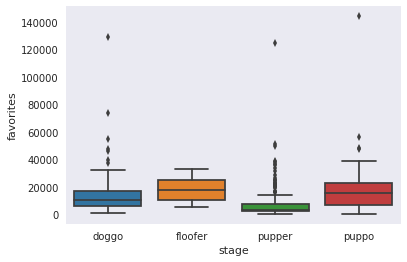

In [25]:
sns.boxplot(data=twitter_clean, x='stage', y='favorites')
sns.despine()

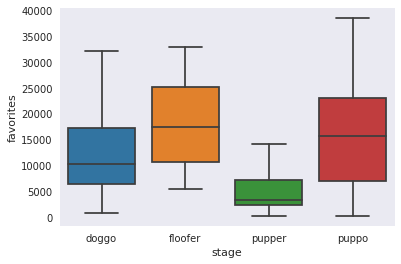

In [26]:
sns.boxplot(data=twitter_clean, x='stage', y='favorites', showfliers=False)
sns.despine()

#### Analysis
I am surprised how few examples of Floofers are present in this dataset; notice only four Floofers exist. This leads to some skew as shown in the `describe` table above. Floofer has a very high mean, at its minimum, first, second, and third quartiles the values are higher than other dog stages. You might expect floofer is perhaps the most popular dog stage; however, the other three stages all have significantly higher maximums. This leads me to suggest the sample size of Floofers are too small to produce meaningful insights that would be applicable to new Floofer data. This analysis is confirmed by the boxplot visualizations.  

The other stages have enough samples to derive insights. It appears Puppo is the most popular dog stage because it has the highest value of any individual date as well as the highest mean and median. These suggest the distribution of Puppo values is higher than those of Doggo and Pupper.

#### Insight 2

In [27]:
twitter_clean['favorites/retweets'] = twitter_clean['favorites'] / twitter_clean['retweets']
time_indexed_twitter = twitter_clean.set_index(pd.DatetimeIndex(twitter_clean['timestamp']))

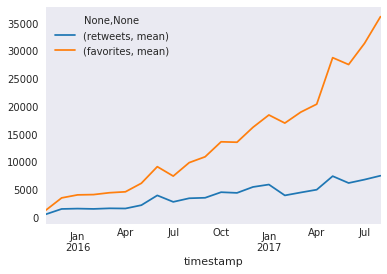

In [28]:
# Monthly grouping
time_indexed_twitter.groupby(pd.Grouper(freq='M'))['retweets', 'favorites'].agg(['mean']).plot()

In [29]:
twitter_clean.groupby('stage')['favorites/retweets'].agg('describe').T

stage,doggo,floofer,pupper,puppo
count,84.000000,4.000000,244.000000,32.000000
mean,4.002320,3.592255,3.250799,6.363637
std,2.440966,1.845826,1.153334,10.873337
min,1.439550,1.820329,1.099476,2.089747
25%,2.889084,2.431561,2.517509,3.243837
50%,3.621602,3.243462,3.068882,3.676548
75%,4.533669,4.404155,3.705095,4.946387
max,21.314286,6.061765,10.153846,64.666667


#### Analysis
I was curious to see if there were correlations between the number of favorites and retweets, particularly as it relates to dog stages. A larger number of favorites than retweets suggests users found the tweet funny, but not humorous enough to warrant retweeting and sharing with their own network. The table above suggests both puppo and doggo had some of the most favorited tweets; however, users did not retweet those tweets and the same proportion for some reason. While Pupper was arguably the least popular dog stage, their favorites to retweets ratio was mostly unaffected by tweet quality.

#### Insight 3

In [30]:
only_dogs = twitter_clean.loc[twitter_clean['dog?'] == True]

In [31]:
top_15_dogs_ratings = only_dogs.groupby('prediction')['rating_numerator']\
                       .agg(['count', 'median'])\
                       .sort_values(by=['count', 'median'], ascending=False)[:15]

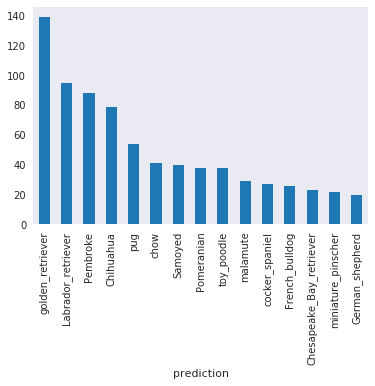

In [32]:
top_15_dogs_ratings['count'].plot(kind='bar')

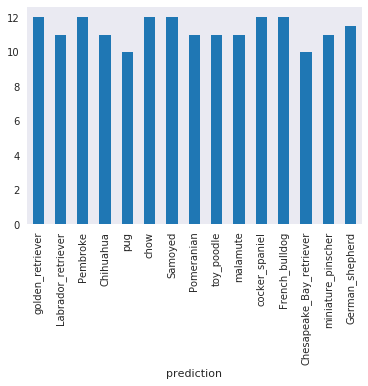

In [19]:
top_15_dogs_ratings['median'].plot(kind='bar')

In [33]:
top_15_dogs_favorites = only_dogs.groupby('prediction')['favorites']\
                       .agg(['count', 'median'])\
                       .sort_values(by=['count', 'median'], ascending=False)[:15]

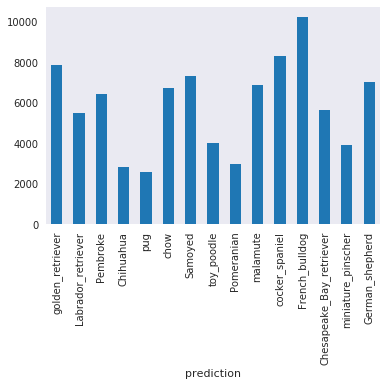

In [20]:
top_15_dogs_favorites['median'].plot(kind='bar')

#### Analysis

While the golden retriever was the most commonly rated dog breed, it appears the French bulldog was actually the most highly favorited among the top 15 dog breeds. The median rating numerator for those top 15 breeds, however, was in the 10 to 12 range. With no real criteria to qualify those ratings, popularity and number of favorites can act as a more accurate representation of favorite dog breeds. 